[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana2/02_Supervivencia_RegresionCox.ipynb)

In [ ]:
# Puede necesitar instalar alguna de estas librerías, solo descomentenlas a necesidad

!pip install lifelines
# !pip install plotly==4.14.3

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=dac73d5dc3e7a086f6c25dcdd3e7ff9a666256dcf712cdf86809dc62eb5eafee
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


### Objetivo

Implementar el análisis de supervivencia a datos sobre prestamos, para esto veremos:
  1. Estimador Kaplan Meier (primer clase)
  2. Modelo de Cox (segunda clase)
  3. Mención de Survival Random Forest (segunda clase)

### Carga

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


Los datos de los prestamos pueden ser encontrados [aquí](https://www.kaggle.com/datasets/yousuf28/prosper-loan). La parte de las etiquetas fue obtenida [aquí](https://github.com/ketra21/prosperloan/blob/master/Prosper%20Loan%20Data%20-%20Variable%20Definitions.csv).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/Kaplan_Meier/prosperLoanData.csv')

In [ ]:
df_dict = pd.read_excel('/content/drive/MyDrive/Cruso-ApsFinancieras/Kaplan_Meier/Prosper Loan Data - Variable Definitions.xlsx')

In [ ]:
df_dict

,Variable,Description
0,ListingKey,"Unique key for each listing, same value as the..."
1,ListingNumber,The number that uniquely identifies the listin...
2,ListingCreationDate,The date the listing was created.
3,CreditGrade,The Credit rating that was assigned at the tim...
4,Term,The length of the loan expressed in months.
...,...,...
76,PercentFunded,Percent the listing was funded.
77,Recommendations,Number of recommendations the borrower had at ...
78,InvestmentFromFriendsCount,Number of friends that made an investment in t...
79,InvestmentFromFriendsAmount,Dollar amount of investments that were made by...


In [ ]:
df_dict_reindex = df_dict.set_index('Variable')

In [ ]:
df_dict_reindex

,Description
Variable,
ListingKey,"Unique key for each listing, same value as the..."
ListingNumber,The number that uniquely identifies the listin...
ListingCreationDate,The date the listing was created.
CreditGrade,The Credit rating that was assigned at the tim...
Term,The length of the loan expressed in months.
...,...
PercentFunded,Percent the listing was funded.
Recommendations,Number of recommendations the borrower had at ...
InvestmentFromFriendsCount,Number of friends that made an investment in t...


In [ ]:
df.head(16)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,20
5,0F05359734824199381F61D,1074836,2013-12-14 08:26:37.093000000,NaN,60,Current,NaN,0.15425,0.1314,0.1214,...,-25.33,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1
6,0F0A3576754255009D63151,750899,2013-04-12 09:52:56.147000000,NaN,36,Current,NaN,0.31032,0.2712,0.2612,...,-22.95,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1
7,0F1035772717087366F9EA7,768193,2013-05-05 06:49:27.493000000,NaN,36,Current,NaN,0.23939,0.2019,0.1919,...,-69.21,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1
8,0F043596202561788EA13D5,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,0.07620,0.0629,0.0529,...,-16.77,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1
9,0F043596202561788EA13D5,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,0.07620,0.0629,0.0529,...,-16.77,0.0,0.00,0.00,0.0,1.0000,0,0,0.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

# Columnas con valores nulos

In [ ]:
(df.isnull().sum() / df.shape[0]).sort_values()

,0
ListingKey,0.000000
ListingNumber,0.000000
ListingCreationDate,0.000000
Term,0.000000
LoanStatus,0.000000
...,...
TotalProsperPaymentsBilled,0.806165
ProsperPrincipalBorrowed,0.806165
ScorexChangeAtTimeOfListing,0.833873
LoanFirstDefaultedCycleNumber,0.851216


In [ ]:
df_dict_reindex.loc['GroupKey', 'Description']

'The Key of the group in which the Borrower is a member of. Value will be null if the borrower does not have a group affiliation.'

In [ ]:
null_percentages = (df.isnull().sum() / df.shape[0]).sort_values()

null_df = null_percentages.reset_index()
null_df.columns = ['Column', 'Null Percentage']


# Creación del gráfico
fig = px.bar(null_df, x='Column', y='Null Percentage',
             title='Porcentaje de valores nulos por columna',
             labels={'Null Percentage': 'Porcentaje de Nulos', 'Column': 'Columna'},
             text='Null Percentage')

fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(yaxis_tickformat=".0%", xaxis_tickangle=45)

fig.show()

## Exploración en columna "ProperRating (numeric)"

In [ ]:
df_dict_reindex.loc['ProsperRating (numeric)', 'Description']

'The  Prosper Rating assigned at the time the listing was created: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA.  Applicable for loans originated after July 2009.'

In [ ]:
df['ProsperRating (numeric)']

,ProsperRating (numeric)
0,NaN
1,6.0
2,NaN
3,6.0
4,3.0
...,...
113932,4.0
113933,6.0
113934,3.0
113935,4.0


In [ ]:
df[df['ProsperRating (numeric)'].isnull()]['LoanOriginationDate']

,LoanOriginationDate
0,2007-09-12 00:00:00
2,2007-01-17 00:00:00
11,2007-10-18 00:00:00
17,2006-08-22 00:00:00
21,2007-12-12 00:00:00
...,...
113921,2005-11-15 00:00:00
113922,2008-08-19 00:00:00
113923,2008-09-23 00:00:00
113926,2006-08-08 00:00:00


In [ ]:
df.dtypes['LoanOriginationDate']

dtype('O')

#### Filtrando columnas

In [ ]:
df_dict_reindex.loc[['LoanKey', 'ProsperRating (numeric)', 'EmploymentStatusDuration',
                    'LoanOriginationDate', 'LoanStatus', 'EmploymentStatus',
                    'ClosedDate', 'Occupation', 'BorrowerState', 'IsBorrowerHomeowner',
                    'StatedMonthlyIncome', 'IncomeRange', 'LoanOriginalAmount'],:]

,Description
Variable,
LoanKey,Unique key for each loan. This is the same key...
ProsperRating (numeric),The Prosper Rating assigned at the time the l...
EmploymentStatusDuration,The length in months of the employment status ...
LoanOriginationDate,The date the loan was originated.
LoanStatus,"The current status of the loan: Cancelled, Ch..."
EmploymentStatus,The employment status of the borrower at the t...
ClosedDate,"Closed date is applicable for Cancelled, Compl..."
Occupation,The Occupation selected by the Borrower at the...
BorrowerState,The two letter abbreviation of the state of th...


In [ ]:
df_sub = df.loc[:, ['LoanKey', 'ProsperRating (numeric)', 'EmploymentStatusDuration',
                    'LoanOriginationDate', 'LoanStatus', 'EmploymentStatus',
                    'ClosedDate', 'Occupation', 'BorrowerState', 'IsBorrowerHomeowner',
                    'StatedMonthlyIncome', 'IncomeRange', 'LoanOriginalAmount']].copy()
df_sub.head(17)

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12 00:00:00,Completed,Self-employed,2009-08-14 00:00:00,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03 00:00:00,Current,Employed,NaN,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17 00:00:00,Completed,Not available,2009-12-17 00:00:00,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01 00:00:00,Current,Employed,NaN,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20 00:00:00,Current,Employed,NaN,Executive,MN,True,9583.333333,"$100,000+",15000
5,C3D63702273952547E79520,5.0,82.0,2013-12-24 00:00:00,Current,Employed,NaN,Professional,NM,True,8333.333333,"$100,000+",15000
6,CE963680102927767790520,2.0,172.0,2013-04-18 00:00:00,Current,Employed,NaN,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000
7,0C87368108902149313D53B,4.0,103.0,2013-05-13 00:00:00,Current,Employed,NaN,Laborer,CA,False,3355.750000,"$25,000-49,999",10000
8,02163700809231365A56A1C,7.0,269.0,2013-12-12 00:00:00,Current,Employed,NaN,Food Service,IL,True,3333.333333,"$25,000-49,999",10000
9,02163700809231365A56A1C,7.0,269.0,2013-12-12 00:00:00,Current,Employed,NaN,Food Service,IL,True,3333.333333,"$25,000-49,999",10000


In [ ]:
df_dict_reindex.loc[['LoanOriginationDate', 'ClosedDate']]

,Description
Variable,
LoanOriginationDate,The date the loan was originated.
ClosedDate,"Closed date is applicable for Cancelled, Compl..."


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   LoanKey                   113937 non-null  object 
 1   ProsperRating (numeric)   84853 non-null   float64
 2   EmploymentStatusDuration  106312 non-null  float64
 3   LoanOriginationDate       113937 non-null  object 
 4   LoanStatus                113937 non-null  object 
 5   EmploymentStatus          111682 non-null  object 
 6   ClosedDate                55089 non-null   object 
 7   Occupation                110349 non-null  object 
 8   BorrowerState             108422 non-null  object 
 9   IsBorrowerHomeowner       113937 non-null  bool   
 10  StatedMonthlyIncome       113937 non-null  float64
 11  IncomeRange               113937 non-null  object 
 12  LoanOriginalAmount        113937 non-null  int64  
dtypes: bool(1), float64(3), int64(1), object(8)


In [ ]:
df_sub['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'], yearfirst=True)
df_sub['ClosedDate'] = pd.to_datetime(df_sub['ClosedDate'], errors='coerce', yearfirst=True)

In [ ]:
df_sub

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,NaT,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000
113933,62D93634569816897D5A276,6.0,21.0,2011-11-07,FinalPaymentInProgress,Employed,NaT,Professional,PA,True,8041.666667,"$75,000-99,999",2000
113934,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,NaT,Other,TX,True,2875.000000,"$25,000-49,999",10000
113935,589536350469116027ED11B,4.0,94.0,2011-11-21,Completed,Full-time,2013-08-13,Food Service,GA,True,3875.000000,"$25,000-49,999",15000


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   LoanKey                   113937 non-null  object        
 1   ProsperRating (numeric)   84853 non-null   float64       
 2   EmploymentStatusDuration  106312 non-null  float64       
 3   LoanOriginationDate       113937 non-null  datetime64[ns]
 4   LoanStatus                113937 non-null  object        
 5   EmploymentStatus          111682 non-null  object        
 6   ClosedDate                55069 non-null   datetime64[ns]
 7   Occupation                110349 non-null  object        
 8   BorrowerState             108422 non-null  object        
 9   IsBorrowerHomeowner       113937 non-null  bool          
 10  StatedMonthlyIncome       113937 non-null  float64       
 11  IncomeRange               113937 non-null  object        
 12  Lo

¿Siguen siendo valores nulos?

In [ ]:
df_sub['ClosedDate']

,ClosedDate
0,2009-08-14
1,NaT
2,2009-12-17
3,NaT
4,NaT
...,...
113932,NaT
113933,NaT
113934,NaT
113935,2013-08-13


In [ ]:
df_sub['LoanKey'].unique().shape

(113066,)

In [ ]:
df_sub = df_sub.drop_duplicates(subset='LoanKey').reset_index(drop=True)
df_sub.shape

(113066, 13)

Revisando el rango máximo de tiempo e ingresos de usuarios

In [ ]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].max()

,0
LoanOriginationDate,2014-03-12 00:00:00
ClosedDate,2014-03-10 00:00:00
StatedMonthlyIncome,1750002.916667


In [ ]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].min()

,0
LoanOriginationDate,2005-11-15 00:00:00
ClosedDate,2005-11-25 00:00:00
StatedMonthlyIncome,0.0


#### Revisando la variable del evento -> LoanStatus

In [ ]:
df_sub.LoanStatus.unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

In [ ]:
df_status = df_sub[df_sub['LoanStatus'].isin([ 'Current', 'Chargedoff', 'Defaulted'])].copy()
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,NaT,Professional,NM,True,8333.333333,"$100,000+",15000
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,NaT,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000


In [ ]:
df_status.LoanStatus.value_counts()

,count
LoanStatus,
Current,55730
Chargedoff,11992
Defaulted,5018


In [ ]:
df_status

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,NaT,Professional,NM,True,8333.333333,"$100,000+",15000
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,NaT,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,NaT,Professional,IN,True,6250.000000,"$75,000-99,999",3000
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,NaT,Analyst,IL,False,8146.666667,"$75,000-99,999",25000
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,NaT,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,NaT,Other,TX,True,2875.000000,"$25,000-49,999",10000


In [ ]:
df_status['LoanStatus_Censored'] = df_status['LoanStatus'].apply(lambda x: 0 if x == 'Current' else 1)

In [ ]:
df_status.head(10)

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000,0
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,NaT,Professional,NM,True,8333.333333,"$100,000+",15000,0
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,NaT,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0
7,0C87368108902149313D53B,4.0,103.0,2013-05-13,Current,Employed,NaT,Laborer,CA,False,3355.750000,"$25,000-49,999",10000,0
8,02163700809231365A56A1C,7.0,269.0,2013-12-12,Current,Employed,NaT,Food Service,IL,True,3333.333333,"$25,000-49,999",10000,0
9,7C083651269973612460D6D,4.0,300.0,2012-05-17,Current,Employed,NaT,Fireman,MD,False,7500.000000,"$75,000-99,999",13500,0
12,C7F936888258982629356F0,6.0,98.0,2013-07-18,Current,Employed,NaT,Construction,AZ,True,5833.333333,"$50,000-74,999",8500,0
13,2BEF3682506622112EC4790,6.0,35.0,2013-05-13,Current,Employed,NaT,Computer Programmer,VA,False,10833.333333,"$100,000+",19330,0


In [ ]:
df_status.LoanStatus_Censored.value_counts()

,count
LoanStatus_Censored,
0,55730
1,17010


In [ ]:
max_date = df_status.ClosedDate.max()
max_date

Timestamp('2014-03-10 00:00:00')

Vamos a arreglar los tiempos para los datos censurados

In [ ]:
df_status.ClosedDate.fillna(max_date, inplace=True)

<ipython-input-39-4314dd99b7c1>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
df_status

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,2014-03-10,Professional,IN,True,6250.000000,"$75,000-99,999",3000,0
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,2014-03-10,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,2014-03-10,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,2014-03-10,Other,TX,True,2875.000000,"$25,000-49,999",10000,0


In [ ]:
df_status['time'] = df_status['ClosedDate'] - df_status['LoanOriginationDate']

In [ ]:
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0,76 days
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0,326 days


Veamos elementos que tiene problemas en la columna "time" (prestamos creados tarde)

In [ ]:
pd.to_timedelta(0, unit='D')

Timedelta('0 days 00:00:00')

In [ ]:
df_status[df_status['time'] < pd.to_timedelta(0, unit='D')]

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
350,AF533708090522326C25572,5.0,170.0,2014-03-11,Current,Self-employed,2014-03-10,Sales - Commission,MN,True,8500.000000,"$100,000+",15000,0,-1 days
620,4DFA3708683811915243DAA,4.0,16.0,2014-03-11,Current,Employed,2014-03-10,Executive,AR,True,16666.666667,"$100,000+",15000,0,-1 days
1015,0A123707932829824CB3593,7.0,0.0,2014-03-11,Current,Other,2014-03-10,NaN,NY,True,4666.666667,"$50,000-74,999",15000,0,-1 days
1159,7CA53708523374364CD4E7E,4.0,140.0,2014-03-11,Current,Employed,2014-03-10,Sales - Retail,MA,False,5833.333333,"$50,000-74,999",13000,0,-1 days
1552,DC303708663304668E74587,5.0,107.0,2014-03-11,Current,Employed,2014-03-10,Police Officer/Correction Officer,NJ,True,10833.333333,"$100,000+",35000,0,-1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112098,E2CE3708409588745D5B733,6.0,240.0,2014-03-11,Current,Employed,2014-03-10,Other,PA,True,8316.666667,"$75,000-99,999",20000,0,-1 days
112301,95E937085415541646C1D10,5.0,45.0,2014-03-11,Current,Employed,2014-03-10,Other,SC,False,2666.666667,"$25,000-49,999",3700,0,-1 days
112309,E5D73709054852205ED2F69,5.0,127.0,2014-03-12,Current,Employed,2014-03-10,Administrative Assistant,MO,False,3333.333333,"$25,000-49,999",5500,0,-2 days
112903,7CB6370931682834173A636,4.0,187.0,2014-03-11,Current,Employed,2014-03-10,Laborer,NY,False,4433.333333,"$50,000-74,999",3000,0,-1 days


In [ ]:
df_status_clean = df_status[df_status['time'] > pd.to_timedelta(0, unit='D')]
df_status_clean.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0,76 days
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0,326 days


In [ ]:
df_status_clean.loc[1, 'time'].days

7

In [ ]:
df_status_clean['time'] = df_status_clean.time.dt.days

<ipython-input-47-831820739ed6>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_status_clean

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0,76
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,2014-03-10,Professional,IN,True,6250.000000,"$75,000-99,999",3000,0,243
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,2014-03-10,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0,47
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,2014-03-10,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0,322
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,2014-03-10,Other,TX,True,2875.000000,"$25,000-49,999",10000,0,77


In [ ]:
df_status_clean.LoanStatus_Censored.value_counts(normalize=True)

,proportion
LoanStatus_Censored,
0,0.764369
1,0.235631


Recordemos: 0 son datos censurados

### Kaplan-Meier

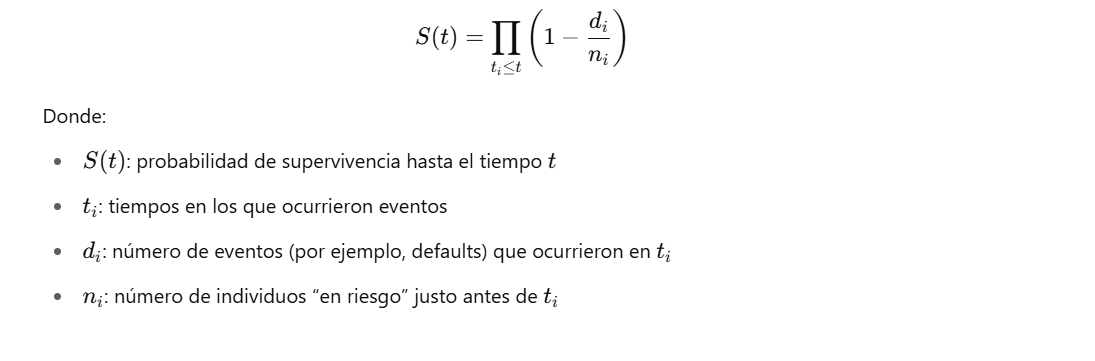

In [ ]:
df_status_clean[['time', 'LoanStatus_Censored']]

,time,LoanStatus_Censored
1,7,0
3,494,0
4,171,0
5,76,0
6,326,0
...,...,...
113059,243,0
113060,47,0
113061,322,0
113063,77,0


In [ ]:
T = df_status_clean.time
E = df_status_clean.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T, event_observed=E)

function = model.survival_function_

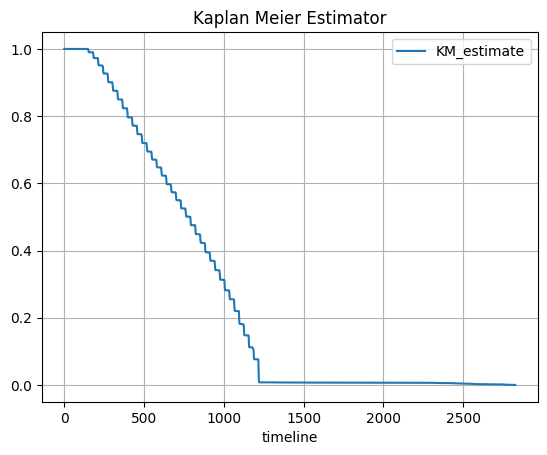

In [ ]:
function.plot(title='Kaplan Meier Estimator')
plt.grid()

In [ ]:
model.median_survival_time_

np.float64(790.0)

In [ ]:
model.event_table.iloc[100:, :]

,removed,observed,censored,entrance,at_risk
event_at,,,,,
149.0,19,19,0,0,49439
150.0,198,9,189,0,49420
151.0,317,87,230,0,49222
152.0,410,209,201,0,48905
153.0,326,116,210,0,48495
...,...,...,...,...,...
2756.0,1,1,0,0,5
2762.0,1,1,0,0,4
2764.0,1,1,0,0,3


In [ ]:
# Accedemos a la tabla de eventos
tabla_de_eventos = model.event_table

# Calculamos los factores (1 - d_i / n_i)
hazard_factors = 1 - (tabla_de_eventos['observed'] / tabla_de_eventos['at_risk'])

# Mostramos los resultados
print(hazard_factors.dropna())

event_at
0.0       1.000000
3.0       1.000000
4.0       1.000000
5.0       1.000000
6.0       1.000000
            ...   
2756.0    0.800000
2762.0    0.750000
2764.0    0.666667
2798.0    0.500000
2825.0    0.000000
Length: 949, dtype: float64


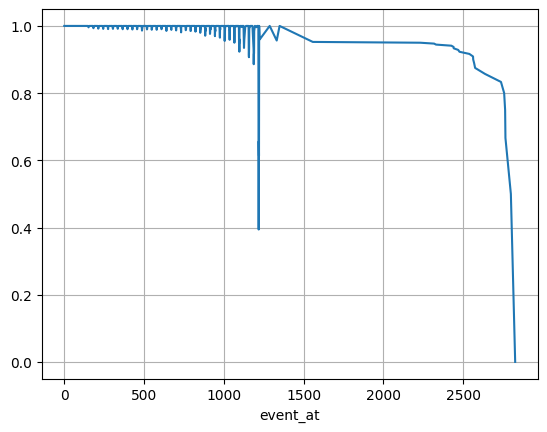

In [ ]:
hazard_factors.plot()
plt.grid()

In [ ]:
hazard_factors.sort_values(ascending=True)

,0
event_at,
2825.0,0.000000
1218.0,0.394118
2798.0,0.500000
1220.0,0.613636
1219.0,0.656716
...,...
27.0,1.000000
4.0,1.000000
3.0,1.000000


In [ ]:
print(model.predict(1000))
print(model.predict(775))

0.3128740685350788
0.5007352556321357


In [ ]:
borrower = (df_status_clean['IsBorrowerHomeowner'] == True)

T = df_status_clean.time
E = df_status_clean.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T[borrower], event_observed=E[borrower], label='Homeowner')
fig_1 = model.survival_function_

model.fit(T[~borrower], event_observed=E[~borrower], label='Not Homeowner')
fig_2 = model.survival_function_


figure = pd.concat([fig_1, fig_2], axis=1)
figure.plot(backend='plotly')

In [ ]:
results = logrank_test(T[borrower], T[~borrower], event_observed_A=E[borrower],
                       event_observed_B=E[~borrower])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         267.13 <0.005    197.06

Entonces se puede rechaza la hipótesis nula de que las funciones de riesgo son iguales (por lo tanto tampoco sus funciones de *supervivencia*)

Es importante señalar que siempre se supone falla!!!

## Supervivencia por ocupación:

In [ ]:
def survival(data, group_field, time_field, event_field):
  """
  Funcion que recibe un DataFrame y filtra por columna

  Returns
    gráfica de la función de supervivencia (Survival function)
    Logrank Test
  """

  model = KaplanMeierFitter()
  results = []
  con_exp = []

  for i in data[group_field].dropna().unique():
    group = data[data[group_field] == i]
    T = group[time_field]
    E = group[event_field]
    con_exp.append([T, E])
    model.fit(T, E, label=str(i))
    results.append(model.survival_function_)

  survival = pd.concat(results, axis=1)


  return survival


In [ ]:
rates = survival(df_status_clean, 'Occupation', 'time', 'LoanStatus_Censored')
rates.plot(kind='scatter', title='Pago completo dependiendo de su ocupación',
           backend='plotly')

In [ ]:
ocupation1 = (df_status_clean['Occupation'] == 'Computer Programmer')
ocupation2 = (df_status_clean['Occupation'] == 'Professor')

T = df_status_clean.time
E = df_status_clean.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T[ocupation1], event_observed=E[ocupation1], label='Computer Programmer')
fig_1 = model.survival_function_

model.fit(T[ocupation2], event_observed=E[ocupation2], label='Professor')
fig_2 = model.survival_function_


figure = pd.concat([fig_1, fig_2], axis=1)
figure.plot(backend='plotly',kind='scatter')

# Segunda Clase

In [ ]:
df_status_clean

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0,76
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,2014-03-10,Professional,IN,True,6250.000000,"$75,000-99,999",3000,0,243
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,2014-03-10,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0,47
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,2014-03-10,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0,322
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,2014-03-10,Other,TX,True,2875.000000,"$25,000-49,999",10000,0,77


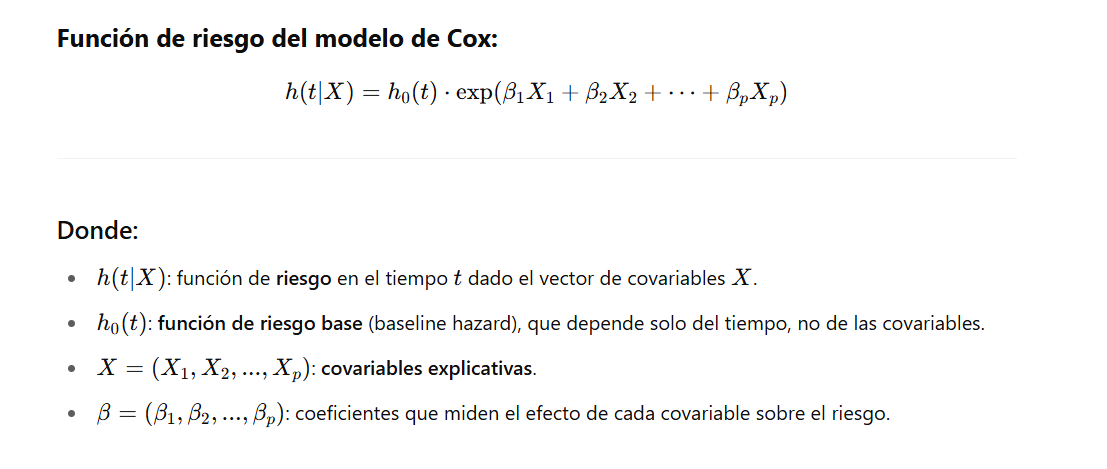

### Cox Model (Segunda Sesión)

In [ ]:
df_status_clean.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171
5,C3D63702273952547E79520,5.0,82.0,2013-12-24,Current,Employed,2014-03-10,Professional,NM,True,8333.333333,"$100,000+",15000,0,76
6,CE963680102927767790520,2.0,172.0,2013-04-18,Current,Employed,2014-03-10,Sales - Retail,KS,False,2083.333333,"$25,000-49,999",3000,0,326


In [ ]:
df_status_clean.EmploymentStatus.value_counts()

,count
EmploymentStatus,
Employed,51909
Full-time,8872
Self-employed,4114
Other,3127
Not available,2269
Not employed,465
Retired,330
Part-time,286


In [ ]:
df_dict_reindex.loc['EmploymentStatus', 'Description']

'The employment status of the borrower at the time they posted the listing.'

In [ ]:
to_model = df_status_clean[['LoanOriginalAmount', 'IsBorrowerHomeowner', 'StatedMonthlyIncome',
                    'time', 'LoanStatus_Censored']].copy()

In [ ]:
to_model

,LoanOriginalAmount,IsBorrowerHomeowner,StatedMonthlyIncome,time,LoanStatus_Censored
1,10000,False,6125.000000,7,0
3,10000,True,2875.000000,494,0
4,15000,True,9583.333333,171,0
5,15000,True,8333.333333,76,0
6,3000,False,2083.333333,326,0
...,...,...,...,...,...
113059,3000,True,6250.000000,243,0
113060,25000,False,8146.666667,47,0
113061,10000,True,4333.333333,322,0
113063,10000,True,2875.000000,77,0


In [ ]:
# Cox Proportional Hazards
model = CoxPHFitter()
model.fit(to_model, duration_col='time', event_col='LoanStatus_Censored')

<lifelines.CoxPHFitter: fitted with 72185 total observations, 55176 right-censored observations>

In [ ]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 72185 total observations, 55176 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 72185
number of events observed = 17009
   partial log-likelihood = -162579.42
         time fit was run = 2025-05-15 23:29:07 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
LoanOriginalAmount  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
IsBorrowerHomeowner -0.10      0.91      0.02           -0.13           -0.06                0.88                0.94
StatedMonthlyIncome -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                     cmp to      z      p  -log2(p)
covariate                                          
LoanOriginalAmount     0.00 -13.26 <0.005    130.92
IsBorrowerHomeowner    0.00  -5.89 <0.005     27.92
StatedMonthlyIncome    0.00 -19.86 <0.005    289.09
---
Concordance = 0.61
Partial AIC = 325164.85
log-likelihood ratio test = 1183.20 on 3 df
-log2(p) of ll-ratio test = 848.72

<Axes: xlabel='log(HR) (95% CI)'>

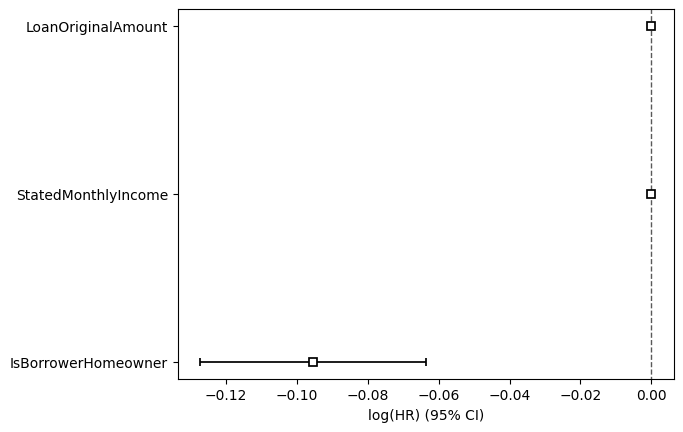

In [ ]:
model.plot()

<Axes: >

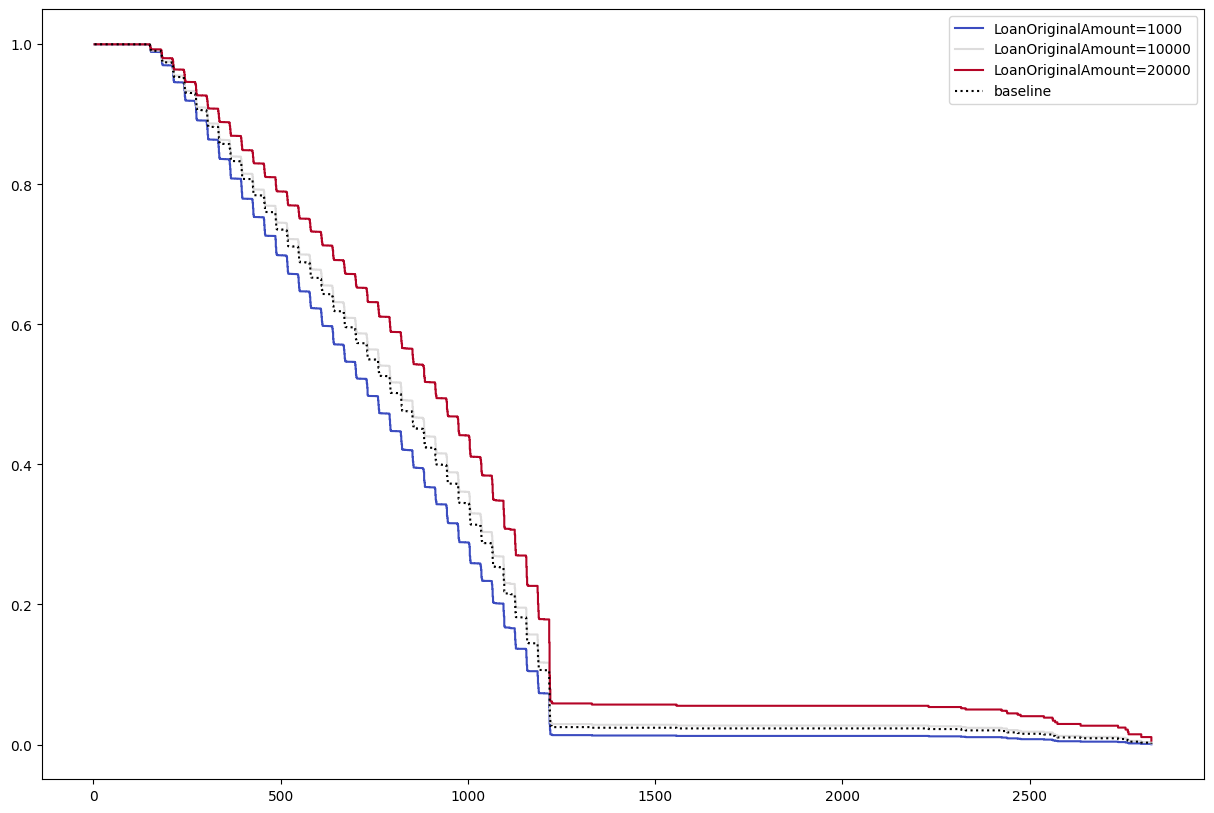

In [ ]:
model.plot_partial_effects_on_outcome(covariates='LoanOriginalAmount',
                                      values=[1000, 10000,
                                              20000], cmap='coolwarm',
                                      figsize=(15, 10))

baseline es $h_0(t)$

Prediciendo riesgos

In [ ]:
to_model[:5]

,LoanOriginalAmount,IsBorrowerHomeowner,StatedMonthlyIncome,time,LoanStatus_Censored
1,10000,False,6125.000000,7,0
3,10000,True,2875.000000,494,0
4,15000,True,9583.333333,171,0
5,15000,True,8333.333333,76,0
6,3000,False,2083.333333,326,0


In [ ]:
model.predict_partial_hazard(to_model[:5])

,0
1,1.015155
3,1.111285
4,0.678100
5,0.728379
6,1.492528


### DF filter 2009


In [ ]:
df_2009 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2009].reset_index(drop=True)
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669
1,FE163568722317050946BE6,6.0,23.0,2009-09-30,Chargedoff,Full-time,2011-06-02,Professional,CA,True,13750.000000,"$100,000+",4500,1,610
2,44523568084532298F4D8C4,3.0,8.0,2009-10-08,Chargedoff,Full-time,2010-06-09,Sales - Commission,TX,False,5200.000000,"$50,000-74,999",4000,1,244
3,CD1335633288951839F5966,2.0,76.0,2009-08-06,Chargedoff,Full-time,2010-09-05,Clerical,CA,False,3333.333333,"$25,000-49,999",4000,1,395
4,74ED3569461592180B471FF,3.0,22.0,2009-10-14,Chargedoff,Full-time,2011-03-16,Other,FL,False,1733.333333,"$1-24,999",4900,1,518


In [ ]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LoanKey                   311 non-null    object        
 1   ProsperRating (numeric)   303 non-null    float64       
 2   EmploymentStatusDuration  311 non-null    float64       
 3   LoanOriginationDate       311 non-null    datetime64[ns]
 4   LoanStatus                311 non-null    object        
 5   EmploymentStatus          311 non-null    object        
 6   ClosedDate                311 non-null    datetime64[ns]
 7   Occupation                311 non-null    object        
 8   BorrowerState             311 non-null    object        
 9   IsBorrowerHomeowner       311 non-null    bool          
 10  StatedMonthlyIncome       311 non-null    float64       
 11  IncomeRange               311 non-null    object        
 12  LoanOriginalAmount    

In [ ]:
# Valores distintos en la columna
df_2009.LoanStatus.unique()

array(['Chargedoff', 'Defaulted'], dtype=object)

In [ ]:
df_2009[['EmploymentStatus']]

,EmploymentStatus
0,Full-time
1,Full-time
2,Full-time
3,Full-time
4,Full-time
...,...
306,Full-time
307,Full-time
308,Full-time
309,Full-time


In [ ]:
dummies = pd.get_dummies(df_2009[['EmploymentStatus']], drop_first=True)
dummies

,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
306,False,False,False,False
307,False,False,False,False
308,False,False,False,False
309,False,False,False,False


In [ ]:
dummies.sum()

,0
EmploymentStatus_Not employed,2
EmploymentStatus_Part-time,10
EmploymentStatus_Retired,7
EmploymentStatus_Self-employed,13


In [ ]:
df_2009.IncomeRange.unique()

array(['$25,000-49,999', '$100,000+', '$50,000-74,999', '$1-24,999',
       '$75,000-99,999', '$0', 'Not employed'], dtype=object)

In [ ]:
def income_range_ordinal(label: str):
  if label in ('$0', 'Not employed'):
    return 0
  elif label == '$1-24,999':
    return 1
  elif label == '$25,000-49,999':
    return 2
  elif label == '$50,000-74,999':
    return 3
  elif label == '$75,000-99,999':
    return 4
  else:
    return 5

In [ ]:
df_2009['IncomeRange_ord'] = df_2009.IncomeRange.apply(income_range_ordinal)

In [ ]:
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord
0,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,2
1,FE163568722317050946BE6,6.0,23.0,2009-09-30,Chargedoff,Full-time,2011-06-02,Professional,CA,True,13750.000000,"$100,000+",4500,1,610,5
2,44523568084532298F4D8C4,3.0,8.0,2009-10-08,Chargedoff,Full-time,2010-06-09,Sales - Commission,TX,False,5200.000000,"$50,000-74,999",4000,1,244,3
3,CD1335633288951839F5966,2.0,76.0,2009-08-06,Chargedoff,Full-time,2010-09-05,Clerical,CA,False,3333.333333,"$25,000-49,999",4000,1,395,2
4,74ED3569461592180B471FF,3.0,22.0,2009-10-14,Chargedoff,Full-time,2011-03-16,Other,FL,False,1733.333333,"$1-24,999",4900,1,518,1


In [ ]:
df_2009_dumm = pd.concat([df_2009, dummies], axis=1)
df_2009_dumm.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,2,False,False,False,False
1,FE163568722317050946BE6,6.0,23.0,2009-09-30,Chargedoff,Full-time,2011-06-02,Professional,CA,True,13750.000000,"$100,000+",4500,1,610,5,False,False,False,False
2,44523568084532298F4D8C4,3.0,8.0,2009-10-08,Chargedoff,Full-time,2010-06-09,Sales - Commission,TX,False,5200.000000,"$50,000-74,999",4000,1,244,3,False,False,False,False
3,CD1335633288951839F5966,2.0,76.0,2009-08-06,Chargedoff,Full-time,2010-09-05,Clerical,CA,False,3333.333333,"$25,000-49,999",4000,1,395,2,False,False,False,False
4,74ED3569461592180B471FF,3.0,22.0,2009-10-14,Chargedoff,Full-time,2011-03-16,Other,FL,False,1733.333333,"$1-24,999",4900,1,518,1,False,False,False,False


In [ ]:
df_2009_num = df_2009_dumm._get_numeric_data()
df_2009_num

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,7.0,74.0,True,3000.000000,5000,1,669,2,False,False,False,False
1,6.0,23.0,True,13750.000000,4500,1,610,5,False,False,False,False
2,3.0,8.0,False,5200.000000,4000,1,244,3,False,False,False,False
3,2.0,76.0,False,3333.333333,4000,1,395,2,False,False,False,False
4,3.0,22.0,False,1733.333333,4900,1,518,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
306,1.0,106.0,False,4833.333333,4000,1,152,3,False,False,False,False
307,7.0,55.0,False,5416.666667,2500,1,364,3,False,False,False,False
308,3.0,29.0,False,6583.333333,7500,1,334,4,False,False,False,False
309,4.0,104.0,True,5833.333333,1000,1,1187,3,False,False,False,False


In [ ]:
null_col = df_2009_num.isnull().sum()
null_col[null_col > 0]

,0
ProsperRating (numeric),8


In [ ]:
df_2009_num.dropna(inplace=True)

In [ ]:
df_2009_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 0 to 310
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ProsperRating (numeric)         303 non-null    float64
 1   EmploymentStatusDuration        303 non-null    float64
 2   IsBorrowerHomeowner             303 non-null    bool   
 3   StatedMonthlyIncome             303 non-null    float64
 4   LoanOriginalAmount              303 non-null    int64  
 5   LoanStatus_Censored             303 non-null    int64  
 6   time                            303 non-null    int64  
 7   IncomeRange_ord                 303 non-null    int64  
 8   EmploymentStatus_Not employed   303 non-null    bool   
 9   EmploymentStatus_Part-time      303 non-null    bool   
 10  EmploymentStatus_Retired        303 non-null    bool   
 11  EmploymentStatus_Self-employed  303 non-null    bool   
dtypes: bool(5), float64(3), int64(4)
memory u

In [ ]:
df_2009_num.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
df_2009_num

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,7.0,74.0,True,3000.000000,5000,1,669,2,False,False,False,False
1,6.0,23.0,True,13750.000000,4500,1,610,5,False,False,False,False
2,3.0,8.0,False,5200.000000,4000,1,244,3,False,False,False,False
3,2.0,76.0,False,3333.333333,4000,1,395,2,False,False,False,False
4,3.0,22.0,False,1733.333333,4900,1,518,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
306,1.0,106.0,False,4833.333333,4000,1,152,3,False,False,False,False
307,7.0,55.0,False,5416.666667,2500,1,364,3,False,False,False,False
308,3.0,29.0,False,6583.333333,7500,1,334,4,False,False,False,False
309,4.0,104.0,True,5833.333333,1000,1,1187,3,False,False,False,False


### Cox Model 2009

In [ ]:
to_model = df_2009_num.copy() #.iloc[:, 0:10]

In [ ]:
to_model

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,7.0,74.0,True,3000.000000,5000,1,669,2,False,False,False,False
1,6.0,23.0,True,13750.000000,4500,1,610,5,False,False,False,False
2,3.0,8.0,False,5200.000000,4000,1,244,3,False,False,False,False
3,2.0,76.0,False,3333.333333,4000,1,395,2,False,False,False,False
4,3.0,22.0,False,1733.333333,4900,1,518,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
306,1.0,106.0,False,4833.333333,4000,1,152,3,False,False,False,False
307,7.0,55.0,False,5416.666667,2500,1,364,3,False,False,False,False
308,3.0,29.0,False,6583.333333,7500,1,334,4,False,False,False,False
309,4.0,104.0,True,5833.333333,1000,1,1187,3,False,False,False,False


In [ ]:
model = CoxPHFitter()
model.fit(to_model, duration_col='time', event_col='LoanStatus_Censored')

model.print_summary()

<lifelines.CoxPHFitter: fitted with 303 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 303
number of events observed = 303
   partial log-likelihood = -1429.58
         time fit was run = 2025-05-15 23:55:28 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
ProsperRating (numeric)        -0.03      0.97      0.04           -0.11            0.04                0.90                1.04
EmploymentStatusDuration        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
IsBorrowerHomeowner            -0.12      0.89      0.13           -0.37            0.13                0.69                1.14
StatedMonthlyIncome             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
LoanOriginalAmount              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
IncomeRange_ord                -0.09      0.91      0.10           -0.28            0.10                0.76                1.10
EmploymentStatus_Not employed   0.66      1.93      0.73           -0.78            2.10                0.46                8.14
EmploymentStatus_Part-time     -0.21      0.81      0.33           -0.85            0.43                0.43                1.54
EmploymentStatus_Retired       -0.10      0.91      0.39           -0.86            0.67                0.42                1.95
EmploymentStatus_Self-employed -0.09      0.92      0.31           -0.70            0.53                0.50                1.69

                                cmp to     z    p  -log2(p)
covariate                                                  
ProsperRating (numeric)           0.00 -0.86 0.39      1.35
EmploymentStatusDuration          0.00  0.25 0.80      0.32
IsBorrowerHomeowner               0.00 -0.92 0.36      1.49
StatedMonthlyIncome               0.00  1.14 0.25      1.98
LoanOriginalAmount                0.00  0.95 0.34      1.55
IncomeRange_ord                   0.00 -0.93 0.35      1.52
EmploymentStatus_Not employed     0.00  0.89 0.37      1.43
EmploymentStatus_Part-time        0.00 -0.65 0.52      0.96
EmploymentStatus_Retired          0.00 -0.25 0.80      0.32
EmploymentStatus_Self-employed    0.00 -0.28 0.78      0.36
---
Concordance = 0.56
Partial AIC = 2879.16
log-likelihood ratio test = 4.91 on 10 df
-log2(p) of ll-ratio test = 0.16

<Axes: xlabel='log(HR) (95% CI)'>

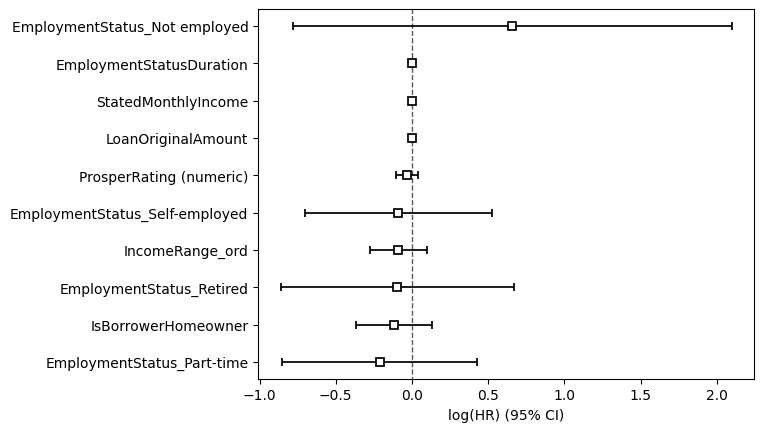

In [ ]:
model.plot()

<Axes: >

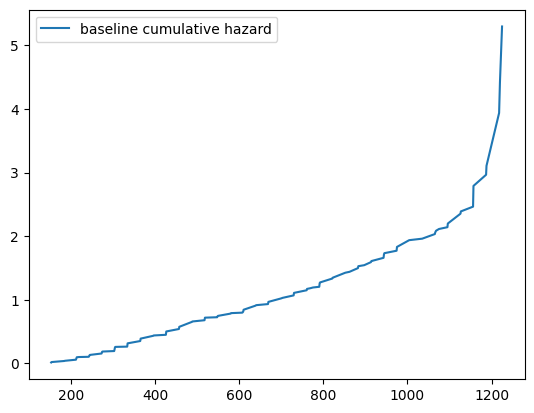

In [ ]:
model.baseline_cumulative_hazard_.plot()

<Axes: >

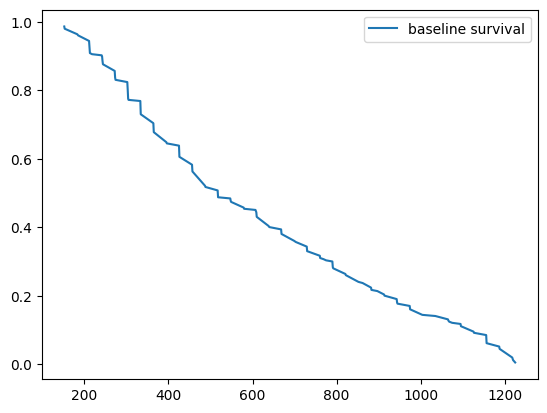

In [ ]:
model.baseline_survival_.plot()

In [ ]:
to_model[100:105]

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
101,1.0,3.0,False,0.000000,3000,1,364,0,True,False,False,False
102,3.0,27.0,False,6000.000000,5000,1,334,3,False,False,False,False
103,3.0,31.0,False,3191.666667,2800,1,302,2,False,False,False,False
104,2.0,32.0,False,2250.000000,3300,1,364,2,False,False,False,False
105,6.0,96.0,True,9166.666667,15000,1,943,5,False,False,False,False


In [ ]:
model.predict_partial_hazard(to_model[100:105])

,0
101,2.335902
102,1.105693
103,1.060900
104,1.069844
105,0.991116


## Caso con estimador paramétrico

<Axes: >

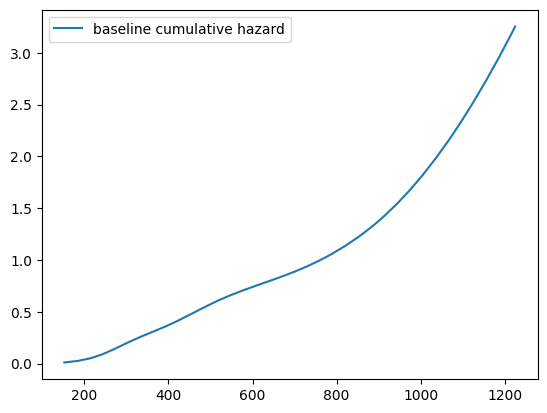

In [ ]:
# Nótese que ahora el objeto CoxHPFitter tiene recibe parámetros de entrada
model = CoxPHFitter(baseline_estimation_method='spline', n_baseline_knots=6)
model.fit(to_model, duration_col='time', event_col='LoanStatus_Censored')

# model.print_summary()
model.baseline_cumulative_hazard_.plot()

<Axes: >

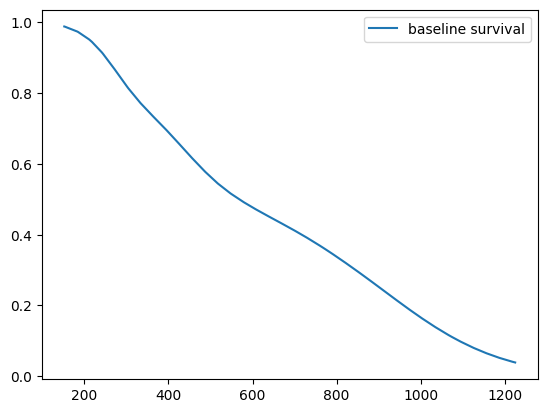

In [ ]:
model.baseline_survival_.plot()

# Random Survival Forest for 2010

In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [ ]:
df_2010 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2010].reset_index(drop=True)
df_2010.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,74323594369048749C7F0D6,4.0,3.0,2010-08-09,Defaulted,Self-employed,2012-05-10,Teacher,CA,True,3333.333333,"$25,000-49,999",6000,1,640
1,07BA3590853980521AC6D4D,3.0,23.0,2010-06-14,Chargedoff,Full-time,2013-10-15,Sales - Retail,TX,False,4183.333333,"$50,000-74,999",2500,1,1219
2,7106360525287128122FEDC,1.0,68.0,2010-11-26,Defaulted,Full-time,2012-03-27,Other,MO,False,3163.333333,"$25,000-49,999",4000,1,487
3,FDF63580685545948001CEE,3.0,91.0,2010-02-26,Chargedoff,Full-time,2011-08-26,Architect,NY,True,8083.333333,"$75,000-99,999",8000,1,546
4,1A5D36055851602094F76C8,3.0,50.0,2010-11-30,Chargedoff,Full-time,2012-01-30,Executive,TN,True,3033.333333,"$25,000-49,999",7500,1,426


In [ ]:
to_model2 = df_2010[['LoanOriginalAmount', 'StatedMonthlyIncome',
                  'time', 'LoanStatus_Censored']].copy()

In [ ]:
to_model2

,LoanOriginalAmount,StatedMonthlyIncome,time,LoanStatus_Censored
0,6000,3333.333333,640,1
1,2500,4183.333333,1219,1
2,4000,3163.333333,487,1
3,8000,8083.333333,546,1
4,7500,3033.333333,426,1
...,...,...,...,...
951,1000,333.333333,303,1
952,10000,4916.666667,701,1
953,2000,3200.000000,304,1
954,2400,4916.666667,573,1


In [ ]:
# Modificación de datos para alimentar el modelo Random Survival Forest
Xt = to_model2[['LoanOriginalAmount', 'StatedMonthlyIncome']]
y = np.array(to_model2[['LoanStatus_Censored', 'time']].apply(tuple, axis=1)).astype([('cens', '?'), ('time', '<f8')])

In [ ]:
to_model2[['LoanStatus_Censored', 'time']]

,LoanStatus_Censored,time
0,1,640
1,1,1219
2,1,487
3,1,546
4,1,426
...,...,...
951,1,303
952,1,701
953,1,304
954,1,573


In [ ]:
from sklearn.model_selection import train_test_split

from sksurv.ensemble import RandomSurvivalForest

In [ ]:
random_state = 40

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [ ]:
y_train[:10]

array([( True, 914.), ( True, 823.), ( True, 546.), ( True, 395.),
       ( True, 548.), ( True, 729.), ( True, 214.), ( True, 245.),
       ( True, 912.), ( True, 792.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, random_state=40)

In [ ]:
# Concordance index
rsf.score(X_train, y_train)

np.float64(0.6182701229985588)

In [ ]:
rsf.score(X_test, y_test)

np.float64(0.5183515661190892)

## Como podemos ver de que servirían las predicciones

Haremos una predicción del riesgo

In [ ]:
rsf.predict(X_test[:5])

array([167.23490491, 115.88849107, 204.26117082, 185.95029526,
       136.42193628])

In [ ]:
y_test[:5]

array([( True,  334.), (False, 1186.), ( True,  487.), ( True,  396.),
       ( True,  517.)], dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
X_test[:5]

,LoanOriginalAmount,StatedMonthlyIncome
512,2900,10000.000000
750,13000,11250.000000
605,2500,6466.666667
617,1500,5833.333333
725,6500,3750.000000
